# Imports

In [81]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import seaborn as sns

import screed
import sklearn

%matplotlib inline

In [2]:
filename

NameError: name 'filename' is not defined

# Get `leaftea translate` ressults

In [ ]:
ls -lha /mnt/data_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/

In [ ]:
ls -lha /mnt/data_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate

### jq transform to see contents

In [37]:
! jq . /mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--run/translate/molecule-protein_ksize-15/Homo_sapiens_9606_qfo_dna_01__molecule-protein_ksize-15__coding_summary.json

{
  "input_files": [
    "Homo_sapiens_9606_qfo_dna_01.fq.gz"
  ],
  "jaccard_info": {
    "count": 2056774,
    "mean": 0.388295798026765,
    "std": 0.4422436270898122,
    "min": 0,
    "25%": 0,
    "50%": 0,
    "75%": 1,
    "max": 1
  },
  "categorization_counts": {
    "Translation is shorter than peptide k-mer size + 1": 1225,
    "Translation frame has stop codon(s)": 19360,
    "Coding": 538372,
    "Non-coding": 456018,
    "Low complexity nucleotide": 0,
    "Read length was shorter than 3 * peptide k-mer size": 0,
    "Low complexity peptide in protein20 alphabet": 26
  },
  "categorization_percentages": {
    "Translation is shorter than peptide k-mer size + 1": 0.12068953626646674,
    "Translation frame has stop codon(s)": 1.9073872833622825,
    "Coding": 53.04152409702059,
    "Non-coding": 44.9278375095197,
    "Low complexity nucleotide": 0,
    "Read length was shorter than 3 * peptide k-mer size": 0,
    "Low complexity peptide in protein20 alphabet": 0.002561573

## Iterate over json summary and read them in

In [21]:
def get_translate_metadata(translate_json_glob, species=None):
    categorization_dict = {}
    n_reads_per_frame_dict = {}
    for filename in tqdm(glob.glob(translate_json_glob)):
        with open(filename) as f:
            data = json.load(f)

        basename = os.path.basename(filename)
        sketch_id = basename.split('__')[1]
        split = sketch_id.split('_')
        alphabet = split[0].split('-')[1]
        ksize = int(split[1].split('-')[1])

        cat = data['categorization_percentages']
        cat_new = {}
        for key, value in cat.items():
            if 'complexity peptide' in key:
                new_key = key.split('in')[0].strip()
            else:
                new_key = key
            cat_new[new_key] = value


        categorization_dict[(alphabet, ksize)] = cat_new
        n_reads_per_frame_dict[(alphabet, ksize)] = data['histogram_n_coding_frames_per_read']

    n_frames_per_read = pd.DataFrame(n_reads_per_frame_dict).T.sort_index()
    n_frames_per_read = n_frames_per_read.fillna(0)
    print('n_frames_per_read.shape', n_frames_per_read.shape)
    n_frames_per_read.head()
    
    n_frames_per_read_tidy = n_frames_per_read.stack().reset_index()
    n_frames_per_read_tidy = n_frames_per_read_tidy.rename(
        columns={'level_0': 'alphabet', 'level_1': 'ksize', 
                 'level_2': 'category', 0: 'n_reads'}
    )
    n_frames_per_read_tidy['n_frames'] = n_frames_per_read_tidy['category'].str.extract('(\d)').astype(int)


    categorization = pd.DataFrame(categorization_dict).T.sort_index()
    # categorization.columns = [for x in categorization.columns]
    # categorization = categorization.groupby(axis=1, level=0).sum()
    print('categorization.shape', categorization.shape)

    # remove categories that are 0 for all alphabets and ksizes
    nonzero_for_all = (categorization > 0).any(axis=0)
    print("Zero for all alpahbets and ksizes:", 
          categorization.columns[~nonzero_for_all])
    categorization = categorization.loc[:, nonzero_for_all]
    categorization = categorization.rename(columns={'Translation is shorter than peptide k-mer size + 1': 'Too few k-mers'})

    print('categorization.shape', categorization.shape)
    categorization.head()
    categorization_tidy = categorization.stack().reset_index()
    categorization_tidy = categorization_tidy.rename(
        columns={'level_0': 'alphabet', 'level_1': 'ksize', 
                 'level_2': 'category', 0: 'percentage'}
    )
    
    # Add species data
    categorization_tidy['species'] = species
    n_frames_per_read_tidy['species'] = species
    
    return n_frames_per_read_tidy, categorization_tidy

## Read translate results for human busco

In [22]:
human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    
!ls -lha $human_busco_dir
human_n_frames_per_read, human_categorization = get_translate_metadata(f'{human_busco_dir}/translate/*/*.json', species='human')
print(human_n_frames_per_read.shape)
human_n_frames_per_read.head()

total 19K
drwxr-xr-x  8 olga czb 4.0K Sep 22 18:31 .
drwxr-xr-x  9 olga czb 4.0K Sep 22 18:44 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:43 blastp
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:43 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:26 sencha
drwxr-xr-x 48 olga czb 4.0K Sep 22 18:42 translate


100%|██████████| 46/46 [00:00<00:00, 625.05it/s]

n_frames_per_read.shape (46, 6)
categorization.shape (46, 7)
Zero for all alpahbets and ksizes: Index(['Low complexity nucleotide', 'Read length was shorter than 3 * peptide k-mer size'], dtype='object')
categorization.shape (46, 5)
(276, 6)


,alphabet,ksize,category,n_reads,n_frames,species
0,dayhoff,9,Number of reads with 1 putative protein-coding...,545857.0,1,human
1,dayhoff,9,Number of reads with 2 putative protein-coding...,181498.0,2,human
2,dayhoff,9,Number of reads with 3 putative protein-coding...,56504.0,3,human
3,dayhoff,9,Number of reads with 4 putative protein-coding...,13199.0,4,human
4,dayhoff,9,Number of reads with 5 putative protein-coding...,2041.0,5,human


### Write concatenated n frames per read, categorization to file

In [54]:
human_n_frames_per_read.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/n_frames_per_read.parquet')
human_categorization.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/categorization.parquet')

## Read translate results for mouse busco

In [34]:
mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
!ls -lha $human_busco_dir
mouse_n_frames_per_read, mouse_categorization = get_translate_metadata(f'{mouse_busco_dir}/translate/*/*.json', species='mouse')
print(mouse_n_frames_per_read.shape)
mouse_n_frames_per_read.head()

total 19K
drwxr-xr-x  8 olga czb 4.0K Sep 22 18:31 .
drwxr-xr-x  9 olga czb 4.0K Sep 22 18:44 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:43 blastp
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:43 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:26 sencha
drwxr-xr-x 48 olga czb 4.0K Sep 22 18:42 translate


100%|██████████| 46/46 [00:00<00:00, 348.81it/s]

n_frames_per_read.shape (46, 6)
categorization.shape (46, 7)
Zero for all alpahbets and ksizes: Index(['Low complexity nucleotide', 'Read length was shorter than 3 * peptide k-mer size'], dtype='object')
categorization.shape (46, 5)
(276, 6)


,alphabet,ksize,category,n_reads,n_frames,species
0,dayhoff,9,Number of reads with 1 putative protein-coding...,445833.0,1,mouse
1,dayhoff,9,Number of reads with 2 putative protein-coding...,149675.0,2,mouse
2,dayhoff,9,Number of reads with 3 putative protein-coding...,44821.0,3,mouse
3,dayhoff,9,Number of reads with 4 putative protein-coding...,10413.0,4,mouse
4,dayhoff,9,Number of reads with 5 putative protein-coding...,1576.0,5,mouse


### Write concatenated n frames per read, categorization to file

In [55]:
mouse_n_frames_per_read.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/n_frames_per_read.parquet')
mouse_categorization.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/categorization.parquet')

### Number frames per read

In [35]:
n_frames_per_read = pd.concat([human_n_frames_per_read, mouse_n_frames_per_read])
print(n_frames_per_read.shape)
n_frames_per_read.head()

(552, 6)


,alphabet,ksize,category,n_reads,n_frames,species
0,dayhoff,9,Number of reads with 1 putative protein-coding...,545857.0,1,human
1,dayhoff,9,Number of reads with 2 putative protein-coding...,181498.0,2,human
2,dayhoff,9,Number of reads with 3 putative protein-coding...,56504.0,3,human
3,dayhoff,9,Number of reads with 4 putative protein-coding...,13199.0,4,human
4,dayhoff,9,Number of reads with 5 putative protein-coding...,2041.0,5,human


#### Actually plot

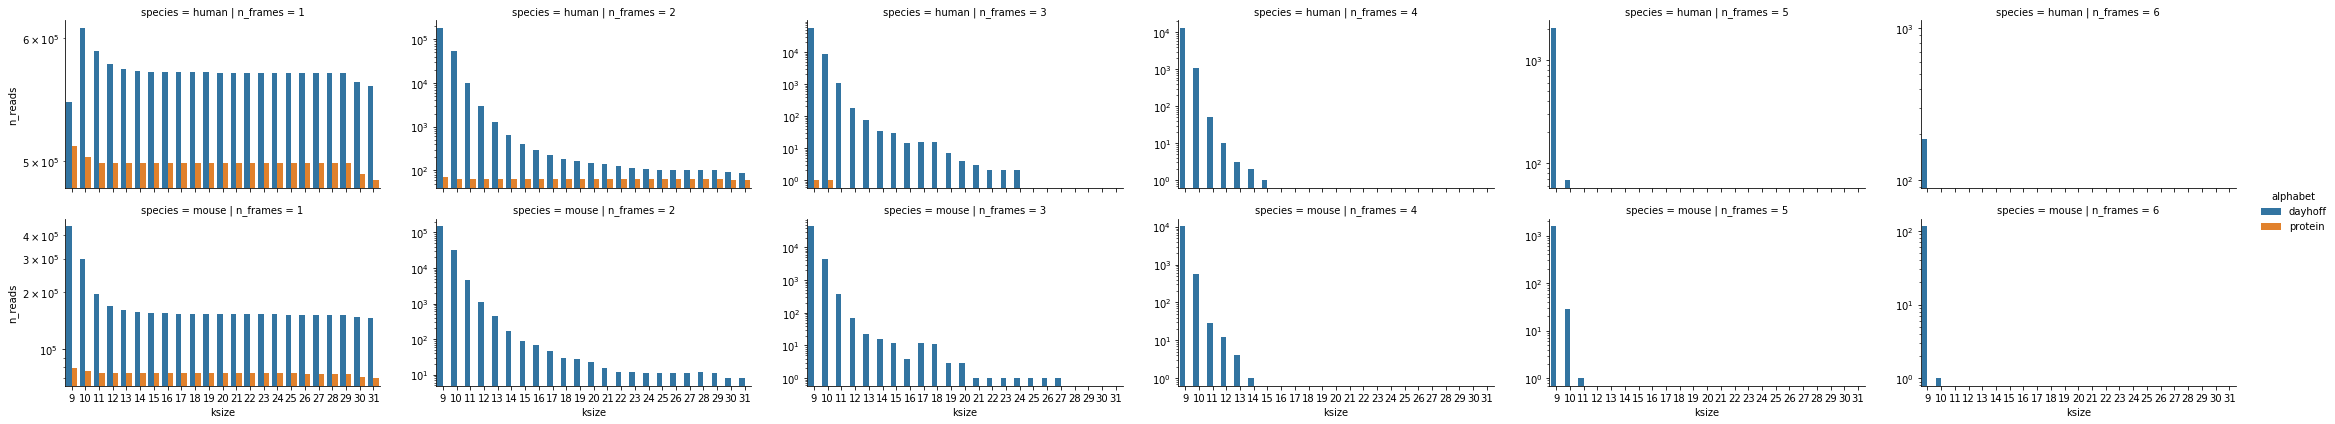

In [36]:
g = sns.catplot(
    x='ksize', y='n_reads', row='species', hue='alphabet',
    col='n_frames',height=3, aspect=1.75,
    data=n_frames_per_read, kind='bar', sharey=False)
g.set(yscale='log')

In [37]:
n_frames_per_read_three_or_fewer = n_frames_per_read.query('n_frames <= 3 ')
n_frames_per_read_three_or_fewer.head()

,alphabet,ksize,category,n_reads,n_frames,species
0,dayhoff,9,Number of reads with 1 putative protein-coding...,545857.0,1,human
1,dayhoff,9,Number of reads with 2 putative protein-coding...,181498.0,2,human
2,dayhoff,9,Number of reads with 3 putative protein-coding...,56504.0,3,human
6,dayhoff,10,Number of reads with 1 putative protein-coding...,609195.0,1,human
7,dayhoff,10,Number of reads with 2 putative protein-coding...,54378.0,2,human


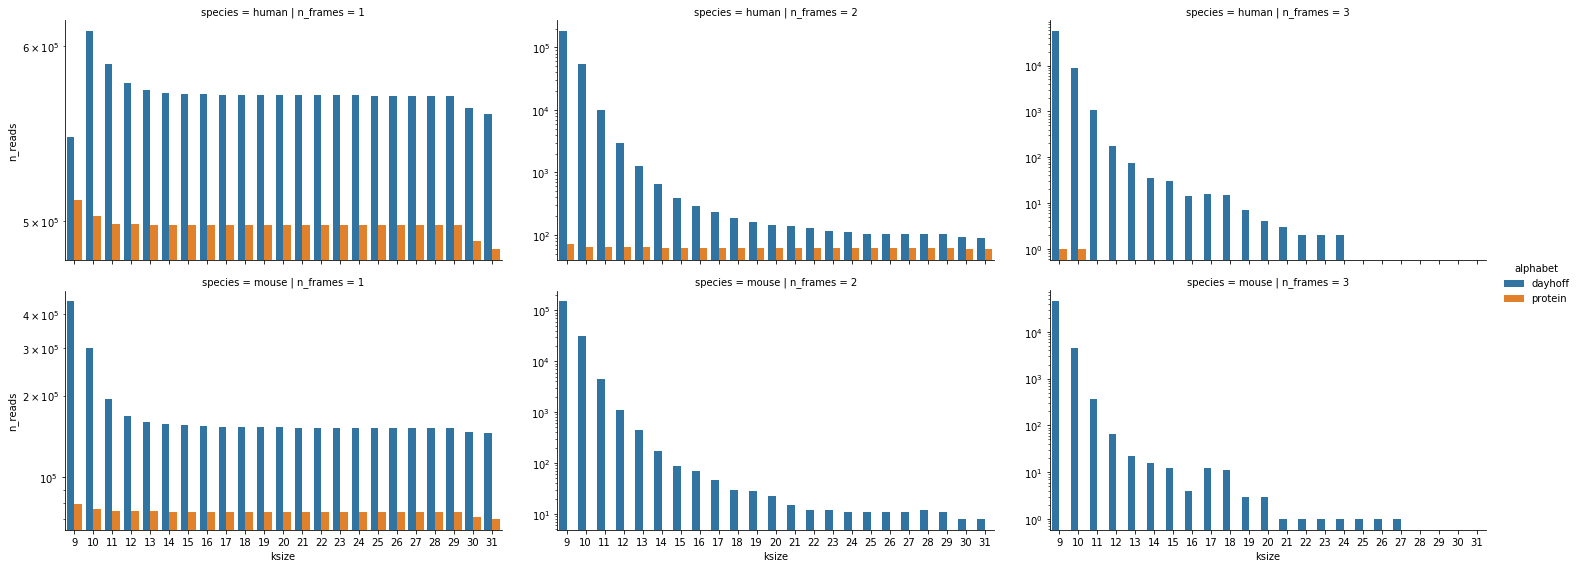

In [38]:
g = sns.catplot(
    x='ksize', y='n_reads', row='species', hue='alphabet',
    col='n_frames',height=4, aspect=1.75,
    data=n_frames_per_read_three_or_fewer, kind='bar', sharey=False)
g.set(yscale='log')

In [40]:
n_frames_per_read_three_or_fewer.query('(alphabet == "protein") & (species == "human") & (ksize == 11)')

,alphabet,ksize,category,n_reads,n_frames,species
150,protein,11,Number of reads with 1 putative protein-coding...,498490.0,1,human
151,protein,11,Number of reads with 2 putative protein-coding...,63.0,2,human
152,protein,11,Number of reads with 3 putative protein-coding...,0.0,3,human


In [ ]:
n_frames_per_read_three_or_fewer.query('(alphabet == "protein") & (species == "human") & (ksize == 11)')

In [31]:
n_frames_per_read.query(
    '(n_frames == 2) & (n_reads == 0) & (alphabet == "dayhoff")'
)

,alphabet,ksize,category,n_reads,n_frames,species
45,dayhoff,16,Number of reads with 4 putative protein-coding...,0.0,4,human
51,dayhoff,17,Number of reads with 4 putative protein-coding...,0.0,4,human
57,dayhoff,18,Number of reads with 4 putative protein-coding...,0.0,4,human
63,dayhoff,19,Number of reads with 4 putative protein-coding...,0.0,4,human
69,dayhoff,20,Number of reads with 4 putative protein-coding...,0.0,4,human
75,dayhoff,21,Number of reads with 4 putative protein-coding...,0.0,4,human
81,dayhoff,22,Number of reads with 4 putative protein-coding...,0.0,4,human
87,dayhoff,23,Number of reads with 4 putative protein-coding...,0.0,4,human
93,dayhoff,24,Number of reads with 4 putative protein-coding...,0.0,4,human
99,dayhoff,25,Number of reads with 4 putative protein-coding...,0.0,4,human


In [32]:
n_frames_per_read.query(
    '(n_frames == 3) & (n_reads == 0) & (alphabet == "dayhoff")'
)

,alphabet,ksize,category,n_reads,n_frames,species
98,dayhoff,25,Number of reads with 3 putative protein-coding...,0.0,3,human
104,dayhoff,26,Number of reads with 3 putative protein-coding...,0.0,3,human
110,dayhoff,27,Number of reads with 3 putative protein-coding...,0.0,3,human
116,dayhoff,28,Number of reads with 3 putative protein-coding...,0.0,3,human
122,dayhoff,29,Number of reads with 3 putative protein-coding...,0.0,3,human
128,dayhoff,30,Number of reads with 3 putative protein-coding...,0.0,3,human
134,dayhoff,31,Number of reads with 3 putative protein-coding...,0.0,3,human
74,dayhoff,28,Number of reads with 3 putative protein-coding...,0.0,3,mouse


In [33]:
n_frames_per_read.query(
    '(n_frames <= 3) & (n_reads > 0) & (alphabet == "protein")')

,alphabet,ksize,category,n_reads,n_frames,species
138,protein,9,Number of reads with 1 putative protein-coding...,511180.0,1,human
139,protein,9,Number of reads with 2 putative protein-coding...,71.0,2,human
140,protein,9,Number of reads with 3 putative protein-coding...,1.0,3,human
144,protein,10,Number of reads with 1 putative protein-coding...,502701.0,1,human
145,protein,10,Number of reads with 2 putative protein-coding...,63.0,2,human
146,protein,10,Number of reads with 3 putative protein-coding...,1.0,3,human
150,protein,11,Number of reads with 1 putative protein-coding...,498490.0,1,human
151,protein,11,Number of reads with 2 putative protein-coding...,63.0,2,human
156,protein,12,Number of reads with 1 putative protein-coding...,498377.0,1,human
157,protein,12,Number of reads with 2 putative protein-coding...,63.0,2,human


# Subset to only reads from complete protein sequences -- no fragments

In [43]:
uniprot_protein_starts_with_m = []

with screed.open('/home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606.fasta') as records:
    for record in records:
        if record['sequence'].startswith("M"):
            uniprot_protein_starts_with_m.append(record['name'].split()[0])
print('uniprot_protein_starts_with_m', len(uniprot_protein_starts_with_m))


uniprot_dna_starts_with_atg = []
with screed.open('/home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606_DNA.fasta') as records:
    for record in records:
        if record['sequence'].startswith("ATG"):
            uniprot_dna_starts_with_atg.append(record['name'].split()[0])
print('uniprot_dna_starts_with_atg', len(uniprot_dna_starts_with_atg))

uniprot_protein_starts_with_m 20483
uniprot_dna_starts_with_atg 20336


In [50]:
uniprot_dna_starts_with_atg[:3]

['tr|A0A024R161|ENSP00000363412',
 'tr|A0A024R1R8|ENSP00000491117',
 'sp|A0A024RBG1|ENSP00000338352']

# Read coding score csvs

## Add read_id_frame and is_coding for computing metrics

In [75]:
def add_read_id_frame_and_is_coding(df):
    df['read_id_frame'] = df.read_id.astype(str) + '__frame=' + df.translation_frame.astype(str)
    df['is_coding'] = df['category'] == "Coding"
    return df

## Get human busco mammalia reads

In [111]:
human_busco_mammalia = pd.read_csv('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/busco_mammalia_human_uniprot_ids.csv')
print(human_busco_mammalia.shape)
human_busco_mammalia.head()

(22539, 3)


,source__uniprot_id,source__id_type,source__db_id
0,P61981,OrthoDB,1176818at2759
1,P27348,OrthoDB,1176818at2759
2,P30443,OrthoDB,1390181at2759
3,Q96QU6,OrthoDB,1156861at2759
4,P10321,OrthoDB,1390181at2759


In [112]:
protein_k11 = human_scores.query('(alphabet == "protein") & (ksize == 11)')
protein_k11.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,read_id_frame,is_coding
152250150,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,40.0,Non-coding,1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False
152250151,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,NaN,NaN,Translation frame has stop codon(s),2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False
152250152,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,39.0,Non-coding,3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False
152250153,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False
152250154,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,39.0,Non-coding,-2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False


In [115]:
protein_k11['read_id'].sample(10).map(lambda x: x.split('/')[1].split(';')[0])

155067802    sp|Q5JRS4|ENSP00000331789
157330458    sp|Q9H094|ENSP00000484028
156186961    sp|Q8NCW6|ENSP00000416787
156190354    sp|Q8ND76|ENSP00000363838
153494246    sp|P10114|ENSP00000245304
156595472    sp|Q92843|ENSP00000452479
155242764    sp|Q63HM1|ENSP00000386890
156443542    sp|Q8TF05|ENSP00000383402
156327856    sp|Q8NHG7|ENSP00000346130
158064290    sp|Q9ULK5|ENSP00000357040
Name: read_id, dtype: object

In [116]:
protein_k11['protein_id'] = protein_k11['read_id'].map(lambda x: x.split('/')[1].split(';')[0])
protein_k11['uniprot_id'] = protein_k11['protein_id'].str.split('|').str[1]
protein_k11.head()

/home/olga/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/olga/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,read_id_frame,is_coding,protein_id,uniprot_id
152250150,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,40.0,Non-coding,1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False,tr|A0A024R1R8|ENSP00000491117,A0A024R1R8
152250151,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,NaN,NaN,Translation frame has stop codon(s),2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False,tr|A0A024R1R8|ENSP00000491117,A0A024R1R8
152250152,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,39.0,Non-coding,3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False,tr|A0A024R1R8|ENSP00000491117,A0A024R1R8
152250153,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False,tr|A0A024R1R8|ENSP00000491117,A0A024R1R8
152250154,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,0.0,39.0,Non-coding,-2,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,11,human,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,False,tr|A0A024R1R8|ENSP00000491117,A0A024R1R8


In [118]:
# protein_k11.query('protein_id in @uniprot_dna_starts_with_atg')

## Function to read coding scores consistently

In [130]:
def read_translate_csvs(globber, species=None):
    dfs = []
    
    for filename in tqdm(glob.glob(globber)):
        dirname = os.path.dirname(filename)
        parent_dir = os.path.basename(dirname)
        molecule_, ksize_ = parent_dir.split('_')
        molecule = molecule_.split('-')[1]
        ksize = int(ksize_.split('-')[1])
        
        df = pd.read_csv(filename)
        df['alphabet'] = molecule
        df['ksize'] = ksize
        df['species'] = species 
        df = add_read_id_frame_and_is_coding(df)
        
        # Get only reads generated from busco mammalia data
        df['protein_id'] = df['read_id'].map(lambda x: x.split('/')[1].split(';')[0])
        df['uniprot_id'] = df['protein_id'].str.split('|').str[1]
        df = df.query('uniprot_id in @human_busco_mammalia.source__uniprot_id')
        
        # Get only reads from transcripts starting with ATG and no Ns
        df = df.query('protein_id in @uniprot_dna_starts_with_atg')
        
        # Only use reads and frames in the gold standard data
        df = df.query('read_id_frame in @true_coding_frame.index')
        
        # Set the read id and frame as the row names
        df = df.set_index('read_id_frame')

        dfs.append(df)
    concatenated = pd.concat(dfs, ignore_index=False)
    concatenated = concatenated.sort_index()
    return concatenated

## Read human coding scores

In [131]:
%%time

human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    
!ls -lha $human_busco_dir
human_scores = read_translate_csvs(f'{human_busco_dir}/translate/*/*.csv', species='human')
print(human_scores.shape)
human_scores.head()

total 51M
drwxr-xr-x  8 olga czb 4.0K Sep 25 19:08 .
drwxr-xr-x  9 olga czb 4.0K Sep 29 08:47 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:43 blastp
-rw-r--r--  1 olga czb  51M Sep 25 19:08 correct_reading_frames.csv
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:43 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:26 sencha
drwxr-xr-x 48 olga czb 8.0K Sep 29 08:05 translate



100%|██████████| 46/46 [38:28<00:00, 50.18s/it]


(127187424, 12)
CPU times: user 53min 7s, sys: 4min 10s, total: 57min 18s
Wall time: 57min 47s


In [132]:
human_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,human,False,sp|O43295|ENSP00000373347,O43295


### Write concatenated n frames per read, categorization to file

In [140]:
human_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet')

## Read mouse coding scores

In [134]:
%%time

mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
!ls -lha $mouse_busco_dir
mouse_scores = read_translate_csvs(f'{mouse_busco_dir}/translate/*/*.csv', species='mouse')
print(mouse_scores.shape)
mouse_scores.head()

total 19K
drwxr-xr-x  8 olga czb 4.0K Sep 22 18:48 .
drwxr-xr-x  9 olga czb 4.0K Sep 29 08:47 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 19:00 blastp
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:44 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:44 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 19:00 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:44 sencha
drwxr-xr-x 48 olga czb 4.0K Sep 30 10:48 translate



100%|██████████| 46/46 [38:11<00:00, 49.81s/it]


(127187424, 12)
CPU times: user 53min 44s, sys: 4min 5s, total: 57min 50s
Wall time: 57min 59s


In [135]:
mouse_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,mouse,False,sp|O43295|ENSP00000373347,O43295


In [136]:
human_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,human,False,sp|O43295|ENSP00000373347,O43295


In [137]:
human_scores.shape

(127187424, 12)

In [138]:
mouse_scores.shape

(127187424, 12)

### Check that human and mouse are not equal

In [139]:
(human_scores.jaccard_in_peptide_db == mouse_scores.jaccard_in_peptide_db).all()

False

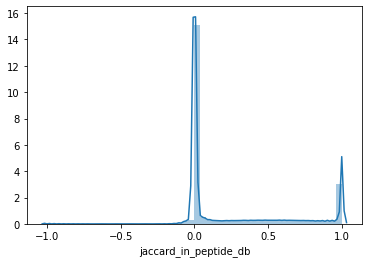

In [143]:
jaccard_diff = human_scores.jaccard_in_peptide_db.subtract(mouse_scores.jaccard_in_peptide_db)
sns.distplot(jaccard_diff.dropna())

In [127]:
! cat $mouse_busco_dir/pipeline_info/pipeline_report.txt

----------------------------------------------------
                                        ,--./,-.
        ___     __   __   __   ___     /,-._.--~\
  |\ | |__  __ /  ` /  \ |__) |__         }  {
  | \| |       \__, \__/ |  \ |___     \`-._,-`-,
                                        `._,._,'
  nf-core/predictorthologs v1.0dev
----------------------------------------------------

Run Name: lonely_volta

## nf-core/predictorthologs execution completed successfully! ##


The workflow was completed at 2020-09-22T19:02:06.392615-07:00 (duration: 16m 50s)

The command used to launch the workflow was as follows:

  nextflow run czbiohub/nf-predictorthologs -r olgabot/fix-skip-trimming -latest -profile docker --skip_trimming --skip_fastqc --reads '/home/olga/data_sm/immune-evolution/rawdata/simulated/human/*.fq.gz' --proteome_search_fasta /home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606.fasta --translate_jaccard_threshold 0.95 --translate_peptide_ks

### Write concatenated n frames per read, categorization to file

In [141]:
mouse_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet')

In [ ]:
ls -lha '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'

# Get gold standard reading frames

## Read gold standard series

In [2]:
human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    


read_id_to_frame = pd.read_csv(f'{human_busco_dir}/correct_reading_frames.csv', index_col=0, squeeze=True)
read_id_to_frame.index.name = 'read_id'
read_id_to_frame = read_id_to_frame.reset_index()
read_id_to_frame['is_coding'] = True
read_id_to_frame['read_id_frame'] = read_id_to_frame.read_id.astype(str) + '__frame=' + read_id_to_frame.translation_frame.astype(str)
read_id_to_frame = read_id_to_frame.set_index('read_id_frame')
print(read_id_to_frame.shape)
read_id_to_frame.head()

(784305, 3)


,read_id,translation_frame,is_coding
read_id_frame,,,
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,read1/tr|A0A024R1R8|ENSP00000491117;mate1Start...,1,True
read2/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,read2/tr|A0A024R1R8|ENSP00000491117;mate1Start...,1,True
read3/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,read3/tr|A0A024R1R8|ENSP00000491117;mate1Start...,1,True
read4/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,read4/tr|A0A024R1R8|ENSP00000491117;mate1Start...,1,True
read5/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1,read5/tr|A0A024R1R8|ENSP00000491117;mate1Start...,1,True


## Make itertools/cartesian product of read id and frames

In [3]:
frames = (1, 2, 3, -1, -2, -3)
all_read_id_frames = [f'{read_id}__frame={frame}' for read_id, frame in itertools.product(read_id_to_frame['read_id'], frames)]
len(all_read_id_frames)

4705830

## Make true coding frame series

In [8]:
true_coding_frame = pd.Series(False, index=all_read_id_frames, name='is_coding')
true_coding_frame[read_id_to_frame.index] = True
true_coding_frame.sum()

784305

In [9]:
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

## WRite to file

In [11]:
true_coding_frame.to_frame().to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet')
true_coding_frame.to_csv('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.csv')

In [18]:
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool